# Exercise 1
____

Bellow, you'll find the code that was used to generate the activity of place cells on a linear track. Use the code and the decoding procedure you learned to explore how different features of the data impact our ability to decode position. 

<font color='teal'> **Q1.1** - Try to use different fractions of the data samples. How does the median error change when the number of available samples gets larger? </font>

<font color='teal'> **Q1.2** - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10, 20, 30,... cells. How does the median error change? </font>

<font color='teal'> **Q1.3** - Generate new data changing the firing rate noise. How does this impact decoding? </font>
_____

In [1]:
import numpy as np
from scipy.stats import poisson
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

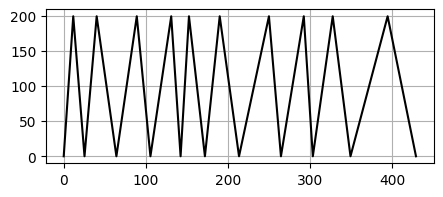

In [2]:
# Generate trajectory
n_runs = 10 
use_stops = False
avg_running_speed = 10
fps = 10
track_length = 200
bins = np.arange(0, track_length)

running_speed_a = np.random.chisquare(10, n_runs)
running_speed_b = np.random.chisquare(10, n_runs)

stopping_time_a = np.random.chisquare(15, n_runs)
stopping_time_b = np.random.chisquare(15, n_runs)

x = np.array([])

for i in range(n_runs):
    
    stop1 = np.zeros( int(stopping_time_a[i] * fps) )
    run_length = int( len(bins) * fps / running_speed_a[i] )
    run1 = np.linspace(0, float(len(bins) - 1), run_length)
    
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins) - 1.)
    run_length = int( len(bins) * fps / running_speed_b[i] )
    run2 = np.linspace(len(bins) - 1, 0, run_length)
    
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))

t = np.arange(len(x)) / fps

plt.figure(figsize=(5,2))
plt.plot(t, x, 'k')
plt.grid()

In [3]:
average_firing_rate = 5   # Peak firing rate, averaged across the population 
n_cells = 100 

pf_centers = np.random.rand(n_cells) * track_length                          # Place field centers
pf_size = np.random.gamma(10, size=n_cells)                                  # Place field widths 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells)     # Peak firing rate for each cell

true_firing_rate_maps = np.zeros((n_cells, len(bins)))

for i in range(n_cells):
    # Gaussian spread firing rate
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp( -(( bins - pf_centers[i])**2 ) / ( 2*pf_size[i]**2 ))

<font color='teal'> **Q1.1** - Try to use different fractions of the data samples. How does the median error change when the number of available samples gets larger? </font>

To explore the effect of using a different number of samples on the median error, we change the former by changing the `sampling_rate` (10, 100, 1000). What we observe is that 

In [6]:
# How many samples we collect each second
sampling_rate = 100

t_sampling = np.arange(0, t[-1], 1 / sampling_rate)

# Given our sampling rate, what actual x's do we record
x_sampling = np.floor(np.interp(t_sampling, t, x)) 
print(len(x_sampling))
noise_firing_rate = 0.1 
spike_times = []

for i in range(n_cells):

    inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate / sampling_rate)
    sp = np.argwhere(spikes_loc) # Find indices of non-zero elements
    t_sp = t_sampling[sp]
    spike_times.append(t_sp)

# Extract the spike counts for each neuron
spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])
spike_counts = spike_counts.T

42860


In [7]:
def bayes_decoding(x, t, firing_rate_map, spike_counts, fps):

    x, t = x[:-1], t[:-1]
    decoded_location = np.zeros(len(x))

    for t_bin in tqdm(range(len(t))):

        # Check if the time bin has spikes
        if sum(spike_counts[t_bin,:]) > 0:
            posterior = np.empty(firing_rate_map.shape[-1])

            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spike_counts[t_bin,:], firing_rate_map[:,i] / fps), pow(1, -15))
            
            decoded_location[t_bin] = bins[np.argmax(posterior)]
        
        else:
            decoded_location[t_bin] = np.nan

    return decoded_location

decoded_locations = bayes_decoding(x,t, true_firing_rate_maps, spike_counts, fps)

  0%|          | 0/4286 [00:00<?, ?it/s]

  7%|▋         | 319/4286 [00:03<00:46, 86.22it/s]


KeyboardInterrupt: 

In [5]:
# Plot the resulting, prediction/decoding
plt.figure(figsize=(6,3))
plt.plot(decoded_locations, '.', color='indianred', label='Decoded')
plt.plot(x[:-1], 'k', label='Ground truth')
plt.grid()
plt.legend(shadow=True)
plt.show()

# Error distribution
mse = np.sqrt((x[:-1] - decoded_locations)**2)
plt.figure(figsize=(8,4))
plt.hist(mse, bins=300, color='teal', alpha=0.75)
plt.axvline(x = np.nanmedian(mse), c='k')
plt.grid()
plt.xlim([0,50])
plt.title('Error distribution')
print(f'Median error: {np.nanmedian(mse)} cm')

NameError: name 'decoded_locations' is not defined

<Figure size 600x300 with 0 Axes>

In [ ]:
sr = np.arange(10, 1000, 50)
medians = np.zeros(len(sr))
for s, sampling_rate in enumerate(sr):
   
    t_sampling = np.arange(0, t[-1], 1 / sampling_rate)   
    x_sampling = np.floor(np.interp(t_sampling, t, x)) 
    noise_firing_rate = 0.1 
    spike_times = []
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc) 
        t_sp = t_sampling[sp]
        spike_times.append(t_sp)
    spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])
    spike_counts = spike_counts.T

    decoded_locations = bayes_decoding(x,t, true_firing_rate_maps, spike_counts, fps)
    mse = np.sqrt((x[:-1] - decoded_locations)**2)
    medians[s] =  np.nanmedian(mse)

In [ ]:
plt.plot(sr, medians,'.-k')
plt.grid()
plt.xlabel('Sampling rate')
plt.ylabel('Median')

<font color='teal'> **Q1.2** - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10, 20, 30,... cells. How does the median error change? </font>


In [ ]:
number_of_cells = np.arange(1,9,1) * 10
sampling_rate = 100
medians_n_cells = []

for n_cells in number_of_cells:
   
    t_sampling = np.arange(0, t[-1], 1 / sampling_rate)   
    x_sampling = np.floor(np.interp(t_sampling, t, x)) 
    noise_firing_rate = 0.1 
    spike_times = []
    
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i, x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate / sampling_rate)
        sp = np.argwhere(spikes_loc) 
        t_sp = t_sampling[sp]
        spike_times.append(t_sp)
    spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])
    spike_counts = spike_counts.T

    decoded_locations = bayes_decoding(x,t, true_firing_rate_maps, spike_counts, fps)
    mse = np.sqrt((x[:-1] - decoded_locations)**2)
    medians_n_cells[s] =  np.nanmedian(mse)